In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir("/content/drive/My Drive")

In [ ]:
import numpy as np
from glob import glob
import cv2

#KNN ON DCT


In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2

def extract_chromatic_channel(bgr_img):
    # Extract 2 chromatic channes from BGR image
    # Input: BGR Image
    # Output: CrCb channels
    ycrcb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCR_CB)
    return ycrcb_image[:, :, 1:]


def block_processing(cb_image, block_size, stride):
    # Divide image into multiple overlap blocks
    # Input: Cr or Cb channel
    # Output: List of blocks
    height, width, _ = cb_image.shape
    img_blocks = []
    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            img_blocks.append(cb_image[i: i + block_size, \
                j: j + block_size])
    return np.array(img_blocks)

def extract_lbp_dct(blocks, n_points = 8, radius = 1):
    # Extract feature vector from given blocks
    # Input: List of blocks response with given image
    # Output: Feature vector of given image
    n_blocks, block_size, _, _ = blocks.shape
    CR_feature = np.zeros((n_blocks, block_size, block_size))
    CB_feature = np.zeros((n_blocks, block_size, block_size))
    for idx, block in enumerate(blocks):
        CR_lbp          = local_binary_pattern(block[:, :, 0], n_points, radius)
        CR_lbp          = np.float32(CR_lbp)
        CR_feature[idx] = cv2.dct(CR_lbp)
        CB_lbp          = local_binary_pattern(block[:, :, 1], n_points, radius)
        CB_lbp          = np.float32(CB_lbp)
        CB_feature[idx] = cv2.dct(CB_lbp)
    CR_feature = np.std(CR_feature, axis = 0).flatten()
    CB_feature = np.std(CB_feature, axis = 0).flatten()
    return np.concatenate([CR_feature, CB_feature], axis = 0)

def extract_feature(cb_image, block_size, stride):
    # Extract feature from given CrCb channels
    # Input: CrCb channels
    # Output: Feature vector or given original image
    img_blocks = block_processing(cb_image, block_size, stride)
    feature    = extract_lbp_dct(img_blocks)
    return feature

def read_and_extract_feature(list_img, block_sizes, strides):
    # Read and extract feature vector from given list images
    total_img = len(list_img)
    dim = 0
    for i in range(len(block_sizes)):
        dim += block_sizes[i] ** 2
    features = np.zeros((total_img, 2*dim))
    for idx in progressbar(range(len(list_img))):
        im         = list_img[idx]
        bgr_img    = cv2.imread(im)
        cb_image   = extract_chromatic_channel(bgr_img)
        tmp        = 0
        for i, bz in enumerate(block_sizes):
            features[idx, tmp: tmp + 2*bz**2] = extract_feature(cb_image, bz, strides[i])
            tmp += 2*bz ** 2
    return features

def process_dataset(folders_real, folders_fake, block_sizes = [16], strides = [8]):
    # Process CASIA dataset
    # Label: 0 - fake image
    #        1 - real image
    list_real = []
    list_fake = []
    for fdr in folders_real:
        list_real += glob.glob(fdr)
    for fdf in folders_fake:
        list_fake += glob.glob(fdf)
    Y_train = np.zeros((len(list_real) + len(list_fake), ), dtype = np.float32)
    Y_train[: len(list_real)] = 1.0
    X_train = read_and_extract_feature(list_real + list_fake, block_sizes = block_sizes, strides = strides)
    return X_train, Y_train
if __name__ == '__main__':
    folder_real = ['/content/drive/MyDrive/casia 1/Au/Au/*.jpg']
    folder_fake = ['/content/drive/MyDrive/casia 1/Tp/*.jpg', '/content/drive/MyDrive/casia 1/Tp/*.tif']

    print('Build kNN model ...')
    X, Y = process_dataset(folder_real, folder_fake)

    print('Build kNN model ...')
    X, Y = shuffle(X, Y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)

    # Choose the number of neighbors (you can adjust this parameter)
    k_value = 5
    knn = KNeighborsClassifier(n_neighbors=k_value)

    # Use cross_val_predict to get predictions for each fold
    y_pred = cross_val_predict(knn, X_train, Y, cv=5)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)


Build kNN model ...


100% (1711 of 1711) |####################| Elapsed Time: 0:20:20 Time:  0:20:20


Build kNN model ...
True Positives: 665
True Negatives: 802
False Positives: 119
False Negatives: 125


In [ ]:
# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Accuracy: 0.8766803039158387
Precision: 0.8754863813229572
Recall: 0.8544303797468354
F1 Score: 0.8648302370275464


In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2

def extract_chromatic_channel(bgr_img):
    # Extract 2 chromatic channes from BGR image
    # Input: BGR Image
    # Output: CrCb channels
    ycrcb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCR_CB)
    return ycrcb_image[:, :, 1:]


def block_processing(cb_image, block_size, stride):
    # Divide image into multiple overlap blocks
    # Input: Cr or Cb channel
    # Output: List of blocks
    height, width, _ = cb_image.shape
    img_blocks = []
    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            img_blocks.append(cb_image[i: i + block_size, \
                j: j + block_size])
    return np.array(img_blocks)

def extract_lbp_dct(blocks, n_points = 8, radius = 1):
    # Extract feature vector from given blocks
    # Input: List of blocks response with given image
    # Output: Feature vector of given image
    n_blocks, block_size, _, _ = blocks.shape
    CR_feature = np.zeros((n_blocks, block_size, block_size))
    CB_feature = np.zeros((n_blocks, block_size, block_size))
    for idx, block in enumerate(blocks):
        CR_lbp          = local_binary_pattern(block[:, :, 0], n_points, radius)
        CR_lbp          = np.float32(CR_lbp)
        CR_feature[idx] = cv2.dct(CR_lbp)
        CB_lbp          = local_binary_pattern(block[:, :, 1], n_points, radius)
        CB_lbp          = np.float32(CB_lbp)
        CB_feature[idx] = cv2.dct(CB_lbp)
    CR_feature = np.std(CR_feature, axis = 0).flatten()
    CB_feature = np.std(CB_feature, axis = 0).flatten()
    return np.concatenate([CR_feature, CB_feature], axis = 0)

def extract_feature(cb_image, block_size, stride):
    # Extract feature from given CrCb channels
    # Input: CrCb channels
    # Output: Feature vector or given original image
    img_blocks = block_processing(cb_image, block_size, stride)
    feature    = extract_lbp_dct(img_blocks)
    return feature

def read_and_extract_feature(list_img, block_sizes, strides):
    # Read and extract feature vector from given list images
    total_img = len(list_img)
    dim = 0
    for i in range(len(block_sizes)):
        dim += block_sizes[i] ** 2
    features = np.zeros((total_img, 2*dim))
    for idx in progressbar(range(len(list_img))):
        im         = list_img[idx]
        bgr_img    = cv2.imread(im)
        cb_image   = extract_chromatic_channel(bgr_img)
        tmp        = 0
        for i, bz in enumerate(block_sizes):
            features[idx, tmp: tmp + 2*bz**2] = extract_feature(cb_image, bz, strides[i])
            tmp += 2*bz ** 2
    return features

def process_dataset(folders_real, folders_fake, block_sizes = [16], strides = [8]):
    # Process CASIA dataset
    # Label: 0 - fake image
    #        1 - real image
    list_real = []
    list_fake = []
    for fdr in folders_real:
        list_real += glob.glob(fdr)
    for fdf in folders_fake:
        list_fake += glob.glob(fdf)
    Y_train = np.zeros((len(list_real) + len(list_fake), ), dtype = np.float32)
    Y_train[: len(list_real)] = 1.0
    X_train = read_and_extract_feature(list_real + list_fake, block_sizes = block_sizes, strides = strides)
    return X_train, Y_train
if __name__ == '__main__':
    folder_real = ['/content/drive/MyDrive/casia 1/Au/Au/*.jpg']
    folder_fake = ['/content/drive/MyDrive/casia 1/Tp/*.jpg', '/content/drive/MyDrive/casia 1/Tp/*.tif']

    print('Build kNN model ...')
    X, Y = process_dataset(folder_real, folder_fake)

    print('Build kNN model ...')
    X, Y = shuffle(X, Y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)

    # Choose the number of neighbors (you can adjust this parameter)
    k_value = 5
    knn = KNeighborsClassifier(n_neighbors=k_value)

    # Use cross_val_predict to get predictions for each fold
    y_pred = cross_val_predict(knn, X_train, Y, cv=5)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)

Build kNN model ...


100% (1711 of 1711) |####################| Elapsed Time: 0:17:03 Time:  0:17:03


Build kNN model ...
True Positives: 672
True Negatives: 812
False Positives: 109
False Negatives: 118


In [ ]:
# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Accuracy: 0.8755113968439509
Precision: 0.8722580645161291
Recall: 0.8556962025316456
F1 Score: 0.8638977635782749


#LDA

In [ ]:
!pip install scikit-fuzzy

from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score, log_loss
from sklearn.utils import shuffle
import skfuzzy as fuzz
import numpy as np
from progressbar import progressbar
import glob
import cv2
import time
import matplotlib.pyplot as plt

def extract_chromatic_channel(bgr_img):
    ycrcb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCR_CB)
    return ycrcb_image[:, :, 1:]

def block_processing(cb_image, block_size, stride):
    height, width, _ = cb_image.shape
    img_blocks = []
    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            img_blocks.append(cb_image[i: i + block_size, j: j + block_size])
    return np.array(img_blocks)

def extract_lbp_dct(blocks, n_points=16, radius=2):
    n_blocks, block_size, _, _ = blocks.shape
    CR_feature = np.zeros((n_blocks, block_size, block_size))
    CB_feature = np.zeros((n_blocks, block_size, block_size))
    for idx, block in enumerate(blocks):
        CR_lbp = local_binary_pattern(block[:, :, 0], n_points, radius)
        CR_lbp = np.float32(CR_lbp)
        CR_feature[idx] = cv2.dct(CR_lbp)
        CB_lbp = local_binary_pattern(block[:, :, 1], n_points, radius)
        CB_lbp = np.float32(CB_lbp)
        CB_feature[idx] = cv2.dct(CB_lbp)
    CR_feature = np.std(CR_feature, axis=0).flatten()
    CB_feature = np.std(CB_feature, axis=0).flatten()
    return np.concatenate([CR_feature, CB_feature], axis=0)

def fuzzy_clustering(features, n_clusters=2):
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(features)
    return fcm.centers.flatten()

def extract_feature(cb_image, block_size, stride, n_clusters=2):
    img_blocks = block_processing(cb_image, block_size, stride)
    lbp_dct_features = extract_lbp_dct(img_blocks)
    fcm_features = fuzzy_clustering(lbp_dct_features.reshape(-1, 1), n_clusters=n_clusters)
    return np.concatenate([lbp_dct_features, fcm_features], axis=0)

def read_and_extract_feature(list_img, block_sizes, strides, n_clusters=2):
    total_img = len(list_img)
    dim = 0
    for i in range(len(block_sizes)):
        dim += block_sizes[i] ** 2
    features = np.zeros((total_img, 2*dim + 2*n_clusters))  # +n_clusters for fuzzy clustering centers
    for idx in progressbar(range(len(list_img))):
        im = list_img[idx]
        bgr_img = cv2.imread(im)
        cb_image = extract_chromatic_channel(bgr_img)
        tmp = 0
        for i, bz in enumerate(block_sizes):
            features[idx, tmp: tmp + 2*bz**2 + n_clusters] = extract_feature(cb_image, bz, strides[i], n_clusters=n_clusters)
            tmp += 2*bz ** 2 + n_clusters
    return features

def process_dataset(folders_real, folders_fake, block_sizes=[16], strides=[8], n_clusters=2):
    list_real = []
    list_fake = []
    for fdr in folders_real:
        list_real += glob.glob(fdr)
    for fdf in folders_fake:
        list_fake += glob.glob(fdf)
    Y_train = np.zeros((len(list_real) + len(list_fake), ), dtype=np.float32)
    Y_train[: len(list_real)] = 1.0
    X_train = read_and_extract_feature(list_real + list_fake, block_sizes=block_sizes, strides=strides, n_clusters=n_clusters)
    return X_train, Y_train

if __name__ == '__main__':
    folder_real = ['/content/drive/MyDrive/casia 1/Au/Au/*.jpg']
    folder_fake = ['/content/drive/MyDrive/casia 1/Tp/*.jpg', '/content/drive/MyDrive/casia 1/Tp/*.tif']

    print('Processing dataset...')
    start_time = time.time()
    X, Y = process_dataset(folder_real, folder_fake)
    print(f"Dataset processed in {time.time() - start_time:.2f} seconds")

    print('Shuffling data...')
    X, Y = shuffle(X, Y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)

    # Apply LDA for dimensionality reduction
    lda = LDA(n_components=1)  # LDA needs to have components less than or equal to the number of classes minus one
    X_train_lda = lda.fit_transform(X_train, Y)

    # Use GridSearchCV to find the best hyperparameters
    param_grid = {'n_neighbors': list(range(1, 31, 2))}  # Expand the search space
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5)
    grid_search.fit(X_train_lda, Y)

    # Get the best model from grid search
    best_knn = grid_search.best_estimator_

    # Use cross_val_predict to get predictions for each fold
    y_pred = cross_val_predict(best_knn, X_train_lda, Y, cv=5)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)

    # Compute ROC curve and AUC
    y_prob = cross_val_predict(best_knn, X_train_lda, Y, cv=5, method='predict_proba')[:, 1]
    fpr, tpr, thresholds = roc_curve(Y, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Compute log loss
    loss = log_loss(Y, y_prob)
    print(f"Log Loss: {loss:.4f}")


Processing dataset...


  0% (0 of 1711) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

NameError: name 'FCM' is not defined

In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2

def extract_chromatic_channel(bgr_img):
    # Extract 2 chromatic channes from BGR image
    # Input: BGR Image
    # Output: CrCb channels
    ycrcb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCR_CB)
    return ycrcb_image[:, :, 1:]


def block_processing(cb_image, block_size, stride):
    # Divide image into multiple overlap blocks
    # Input: Cr or Cb channel
    # Output: List of blocks
    height, width, _ = cb_image.shape
    img_blocks = []
    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            img_blocks.append(cb_image[i: i + block_size, \
                j: j + block_size])
    return np.array(img_blocks)

def extract_lbp_dct(blocks, n_points = 8, radius = 1):
    # Extract feature vector from given blocks
    # Input: List of blocks response with given image
    # Output: Feature vector of given image
    n_blocks, block_size, _, _ = blocks.shape
    CR_feature = np.zeros((n_blocks, block_size, block_size))
    CB_feature = np.zeros((n_blocks, block_size, block_size))
    for idx, block in enumerate(blocks):
        CR_lbp          = local_binary_pattern(block[:, :, 0], n_points, radius)
        CR_lbp          = np.float32(CR_lbp)
        CR_feature[idx] = cv2.dct(CR_lbp)
        CB_lbp          = local_binary_pattern(block[:, :, 1], n_points, radius)
        CB_lbp          = np.float32(CB_lbp)
        CB_feature[idx] = cv2.dct(CB_lbp)
    CR_feature = np.std(CR_feature, axis = 0).flatten()
    CB_feature = np.std(CB_feature, axis = 0).flatten()
    return np.concatenate([CR_feature, CB_feature], axis = 0)

def extract_feature(cb_image, block_size, stride):
    # Extract feature from given CrCb channels
    # Input: CrCb channels
    # Output: Feature vector or given original image
    img_blocks = block_processing(cb_image, block_size, stride)
    feature    = extract_lbp_dct(img_blocks)
    return feature

def read_and_extract_feature(list_img, block_sizes, strides):
    # Read and extract feature vector from given list images
    total_img = len(list_img)
    dim = 0
    for i in range(len(block_sizes)):
        dim += block_sizes[i] ** 2
    features = np.zeros((total_img, 2*dim))
    for idx in progressbar(range(len(list_img))):
        im         = list_img[idx]
        bgr_img    = cv2.imread(im)
        cb_image   = extract_chromatic_channel(bgr_img)
        tmp        = 0
        for i, bz in enumerate(block_sizes):
            features[idx, tmp: tmp + 2*bz**2] = extract_feature(cb_image, bz, strides[i])
            tmp += 2*bz ** 2
    return features

def process_dataset(folders_real, folders_fake, block_sizes = [16], strides = [8]):
    # Process CASIA dataset
    # Label: 0 - fake image
    #        1 - real image
    list_real = []
    list_fake = []
    for fdr in folders_real:
        list_real += glob.glob(fdr)
    for fdf in folders_fake:
        list_fake += glob.glob(fdf)
    Y_train = np.zeros((len(list_real) + len(list_fake), ), dtype = np.float32)
    Y_train[: len(list_real)] = 1.0
    X_train = read_and_extract_feature(list_real + list_fake, block_sizes = block_sizes, strides = strides)
    return X_train, Y_train

if __name__ == '__main__':
    folder_real = ['/content/drive/MyDrive/casia 1/Au/Au/*.jpg']
    folder_fake = ['/content/drive/MyDrive/casia 1/Tp/*.jpg', '/content/drive/MyDrive/casia 1/Tp/*.tif']

    print('Build LDA model ...')
    X, Y = process_dataset(folder_real, folder_fake)

    print('Build LDA model ...')
    X, Y = shuffle(X, Y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)

    lda = LDA()

    # Use cross_val_predict to get predictions for each fold
    y_pred = cross_val_predict(lda, X_train, Y, cv=5)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)

Build LDA model ...


100% (1711 of 1711) |####################| Elapsed Time: 0:19:45 Time:  0:19:45


Build LDA model ...
True Positives: 755
True Negatives: 897
False Positives: 24
False Negatives: 35


In [ ]:
# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Accuracy: 0.9655172413793104
Precision: 0.9691912708600771
Recall: 0.9556962025316456
F1 Score: 0.9623964308476737


#LogisticRegression for DCT

In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2

def extract_chromatic_channel(bgr_img):
    # Extract 2 chromatic channes from BGR image
    # Input: BGR Image
    # Output: CrCb channels
    ycrcb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCR_CB)
    return ycrcb_image[:, :, 1:]


def block_processing(cb_image, block_size, stride):
    # Divide image into multiple overlap blocks
    # Input: Cr or Cb channel
    # Output: List of blocks
    height, width, _ = cb_image.shape
    img_blocks = []
    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            img_blocks.append(cb_image[i: i + block_size, \
                j: j + block_size])
    return np.array(img_blocks)

def extract_lbp_dct(blocks, n_points = 8, radius = 1):
    # Extract feature vector from given blocks
    # Input: List of blocks response with given image
    # Output: Feature vector of given image
    n_blocks, block_size, _, _ = blocks.shape
    CR_feature = np.zeros((n_blocks, block_size, block_size))
    CB_feature = np.zeros((n_blocks, block_size, block_size))
    for idx, block in enumerate(blocks):
        CR_lbp          = local_binary_pattern(block[:, :, 0], n_points, radius)
        CR_lbp          = np.float32(CR_lbp)
        CR_feature[idx] = cv2.dct(CR_lbp)
        CB_lbp          = local_binary_pattern(block[:, :, 1], n_points, radius)
        CB_lbp          = np.float32(CB_lbp)
        CB_feature[idx] = cv2.dct(CB_lbp)
    CR_feature = np.std(CR_feature, axis = 0).flatten()
    CB_feature = np.std(CB_feature, axis = 0).flatten()
    return np.concatenate([CR_feature, CB_feature], axis = 0)

def extract_feature(cb_image, block_size, stride):
    # Extract feature from given CrCb channels
    # Input: CrCb channels
    # Output: Feature vector or given original image
    img_blocks = block_processing(cb_image, block_size, stride)
    feature    = extract_lbp_dct(img_blocks)
    return feature

def read_and_extract_feature(list_img, block_sizes, strides):
    # Read and extract feature vector from given list images
    total_img = len(list_img)
    dim = 0
    for i in range(len(block_sizes)):
        dim += block_sizes[i] ** 2
    features = np.zeros((total_img, 2*dim))
    for idx in progressbar(range(len(list_img))):
        im         = list_img[idx]
        bgr_img    = cv2.imread(im)
        cb_image   = extract_chromatic_channel(bgr_img)
        tmp        = 0
        for i, bz in enumerate(block_sizes):
            features[idx, tmp: tmp + 2*bz**2] = extract_feature(cb_image, bz, strides[i])
            tmp += 2*bz ** 2
    return features

def process_dataset(folders_real, folders_fake, block_sizes = [16], strides = [8]):
    # Process CASIA dataset
    # Label: 0 - fake image
    #        1 - real image
    list_real = []
    list_fake = []
    for fdr in folders_real:
        list_real += glob.glob(fdr)
    for fdf in folders_fake:
        list_fake += glob.glob(fdf)
    Y_train = np.zeros((len(list_real) + len(list_fake), ), dtype = np.float32)
    Y_train[: len(list_real)] = 1.0
    X_train = read_and_extract_feature(list_real + list_fake, block_sizes = block_sizes, strides = strides)
    return X_train, Y_train

if __name__ == '__main__':
    folder_real = ['/content/drive/MyDrive/casia 1/Au/Au/*.jpg']
    folder_fake = ['/content/drive/MyDrive/casia 1/Tp/*.jpg', '/content/drive/MyDrive/casia 1/Tp/*.tif']

    print('Build Logistic Regression model ...')
    X, Y = process_dataset(folder_real, folder_fake)

    print('Build Logistic Regression model ...')
    X, Y = shuffle(X, Y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)

    logreg = LogisticRegression()

    # Use cross_val_predict to get predictions for each fold
    y_pred = cross_val_predict(logreg, X_train, Y, cv=5)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)

Build Logistic Regression model ...


100% (1711 of 1711) |####################| Elapsed Time: 0:20:39 Time:  0:20:39
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Build Logistic Regression model ...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

True Positives: 770
True Negatives: 906
False Positives: 15
False Negatives: 20


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Accuracy: 0.9795441262419637
Precision: 0.9808917197452229
Recall: 0.9746835443037974
F1 Score: 0.9777777777777777


#DCT on casia2



In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2

def extract_chromatic_channel(bgr_img):
    # Extract 2 chromatic channes from BGR image
    # Input: BGR Image
    # Output: CrCb channels
    ycrcb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCR_CB)
    return ycrcb_image[:, :, 1:]


def block_processing(cb_image, block_size, stride):
    # Divide image into multiple overlap blocks
    # Input: Cr or Cb channel
    # Output: List of blocks
    height, width, _ = cb_image.shape
    img_blocks = []
    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            img_blocks.append(cb_image[i: i + block_size, \
                j: j + block_size])
    return np.array(img_blocks)

def extract_lbp_dct(blocks, n_points = 8, radius = 1):
    # Extract feature vector from given blocks
    # Input: List of blocks response with given image
    # Output: Feature vector of given image
    n_blocks, block_size, _, _ = blocks.shape
    CR_feature = np.zeros((n_blocks, block_size, block_size))
    CB_feature = np.zeros((n_blocks, block_size, block_size))
    for idx, block in enumerate(blocks):
        CR_lbp          = local_binary_pattern(block[:, :, 0], n_points, radius)
        CR_lbp          = np.float32(CR_lbp)
        CR_feature[idx] = cv2.dct(CR_lbp)
        CB_lbp          = local_binary_pattern(block[:, :, 1], n_points, radius)
        CB_lbp          = np.float32(CB_lbp)
        CB_feature[idx] = cv2.dct(CB_lbp)
    CR_feature = np.std(CR_feature, axis = 0).flatten()
    CB_feature = np.std(CB_feature, axis = 0).flatten()
    return np.concatenate([CR_feature, CB_feature], axis = 0)

def extract_feature(cb_image, block_size, stride):
    # Extract feature from given CrCb channels
    # Input: CrCb channels
    # Output: Feature vector or given original image
    img_blocks = block_processing(cb_image, block_size, stride)
    feature    = extract_lbp_dct(img_blocks)
    return feature

def read_and_extract_feature(list_img, block_sizes, strides):
    # Read and extract feature vector from given list images
    total_img = len(list_img)
    dim = 0
    for i in range(len(block_sizes)):
        dim += block_sizes[i] ** 2
    features = np.zeros((total_img, 2*dim))
    for idx in progressbar(range(len(list_img))):
        im         = list_img[idx]
        bgr_img    = cv2.imread(im)
        cb_image   = extract_chromatic_channel(bgr_img)
        tmp        = 0
        for i, bz in enumerate(block_sizes):
            features[idx, tmp: tmp + 2*bz**2] = extract_feature(cb_image, bz, strides[i])
            tmp += 2*bz ** 2
    return features

def process_dataset(folders_real, folders_fake, block_sizes = [16], strides = [8]):
    # Process CASIA dataset
    # Label: 0 - fake image
    #        1 - real image
    list_real = []
    list_fake = []
    for fdr in folders_real:
        list_real += glob.glob(fdr)
    for fdf in folders_fake:
        list_fake += glob.glob(fdf)
    Y_train = np.zeros((len(list_real) + len(list_fake), ), dtype = np.float32)
    Y_train[: len(list_real)] = 1.0
    X_train = read_and_extract_feature(list_real + list_fake, block_sizes = block_sizes, strides = strides)
    return X_train, Y_train

if __name__ == '__main__':
    folder_real = ['/content/drive/MyDrive/casia 1/Au/Au/*.jpg']
    folder_fake = ['/content/drive/MyDrive/casia 1/Tp/*.jpg', '/content/drive/MyDrive/casia 1/Tp/*.tif']

    print('Build SVM model ...')
    X, Y = process_dataset(folder_real, folder_fake)

    print('Build SVM model ...')
    X, Y = shuffle(X, Y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)

    svm = SVC(kernel='linear')  # You can choose a different kernel if needed

    # Use cross_val_predict to get predictions for each fold
    y_pred = cross_val_predict(svm, X_train, Y, cv=5)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)

Build SVM model ...


100% (1711 of 1711) |####################| Elapsed Time: 0:09:29 Time:  0:09:29


Build SVM model ...
True Positives: 765
True Negatives: 901
False Positives: 20
False Negatives: 25


In [ ]:
# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Accuracy: 0.9736995908825249
Precision: 0.9745222929936306
Recall: 0.9683544303797469
F1 Score: 0.9714285714285714


#Logisticregression on DFT

In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2

def extract_chromatic_channel(bgr_img):
    # Extract 2 chromatic channels from BGR image
    # Input: BGR Image
    # Output: CrCb channels
    ycrcb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCR_CB)
    return ycrcb_image[:, :, 1:]


def block_processing(cb_image, block_size, stride):
    # Divide image into multiple overlap blocks
    # Input: Cr or Cb channel
    # Output: List of blocks
    height, width, _ = cb_image.shape
    img_blocks = []
    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            img_blocks.append(cb_image[i: i + block_size, j: j + block_size])
    return np.array(img_blocks)

def extract_lbp_dft(blocks, n_points=8, radius=1):
    # Extract feature vector from given blocks
    # Input: List of blocks response with given image
    # Output: Feature vector of given image
    n_blocks, block_size, _, _ = blocks.shape
    CR_feature = np.zeros((n_blocks, block_size, block_size))
    CB_feature = np.zeros((n_blocks, block_size, block_size))

    for idx, block in enumerate(blocks):
        # Extract LBP features
        CR_lbp = local_binary_pattern(block[:, :, 0], n_points, radius)
        CR_lbp = np.float32(CR_lbp)

        CB_lbp = local_binary_pattern(block[:, :, 1], n_points, radius)
        CB_lbp = np.float32(CB_lbp)

        # Replace DCT with DFT
        CR_feature[idx] = np.fft.fft2(CR_lbp)
        CB_feature[idx] = np.fft.fft2(CB_lbp)

    # Compute standard deviation
    CR_feature = np.std(CR_feature, axis=0).flatten()
    CB_feature = np.std(CB_feature, axis=0).flatten()

    return np.concatenate([CR_feature, CB_feature], axis=0)

def extract_feature(cb_image, block_size, stride):
    # Extract feature from given CrCb channels
    # Input: CrCb channels
    # Output: Feature vector of given original image
    img_blocks = block_processing(cb_image, block_size, stride)
    feature = extract_lbp_dft(img_blocks)
    return feature

def read_and_extract_feature(list_img, block_sizes, strides):
    # Read and extract feature vector from given list images
    total_img = len(list_img)
    dim = 0
    for i in range(len(block_sizes)):
        dim += block_sizes[i] ** 2
    features = np.zeros((total_img, 2 * dim))
    for idx in progressbar(range(len(list_img))):
        im = list_img[idx]
        bgr_img = cv2.imread(im)
        cb_image = extract_chromatic_channel(bgr_img)
        tmp = 0
        for i, bz in enumerate(block_sizes):
            features[idx, tmp: tmp + 2 * bz ** 2] = extract_feature(cb_image, bz, strides[i])
            tmp += 2 * bz ** 2
    return features

def process_dataset(folders_real, folders_fake, block_sizes=[16], strides=[8]):
    # Process CASIA dataset
    # Label: 0 - fake image
    #        1 - real image
    list_real = []
    list_fake = []
    for fdr in folders_real:
        list_real += glob.glob(fdr)
    for fdf in folders_fake:
        list_fake += glob.glob(fdf)
    Y_train = np.zeros((len(list_real) + len(list_fake),), dtype=np.float32)
    Y_train[: len(list_real)] = 1.0
    X_train = read_and_extract_feature(list_real + list_fake, block_sizes=block_sizes, strides=strides)
    return X_train, Y_train
if __name__ == '__main__':
    folder_real = ['/content/drive/MyDrive/casia 1/Au/Au/*.jpg']
    folder_fake = ['/content/drive/MyDrive/casia 1/Tp/*.jpg', '/content/drive/MyDrive/casia 1/Tp/*.tif']

    print('Build Logistic Regression model ...')
    X, Y = process_dataset(folder_real, folder_fake)

    print('Build Logistic Regression model ...')
    X, Y = shuffle(X, Y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)

    logreg = LogisticRegression()

    # Use cross_val_predict to get predictions for each fold
    y_pred = cross_val_predict(logreg, X_train, Y, cv=5)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)

    # Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Build Logistic Regression model ...


  0% (0 of 1711) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--<ipython-input-4-61001cef16dc>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  CR_feature[idx] = np.fft.fft2(CR_lbp)
<ipython-input-4-61001cef16dc>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  CB_feature[idx] = np.fft.fft2(CB_lbp)
100% (1711 of 1711) |####################| Elapsed Time: 0:19:23 Time:  0:19:23
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Build Logistic Regression model ...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

True Positives: 744
True Negatives: 896
False Positives: 25
False Negatives: 46
Accuracy: 0.9585037989479837
Precision: 0.9674902470741222
Recall: 0.9417721518987342
F1 Score: 0.9544579858883899


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#LDA on DFT

In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2

def extract_chromatic_channel(bgr_img):
    # Extract 2 chromatic channels from BGR image
    # Input: BGR Image
    # Output: CrCb channels
    ycrcb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCR_CB)
    return ycrcb_image[:, :, 1:]


def block_processing(cb_image, block_size, stride):
    # Divide image into multiple overlap blocks
    # Input: Cr or Cb channel
    # Output: List of blocks
    height, width, _ = cb_image.shape
    img_blocks = []
    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            img_blocks.append(cb_image[i: i + block_size, j: j + block_size])
    return np.array(img_blocks)

def extract_lbp_dft(blocks, n_points=8, radius=1):
    # Extract feature vector from given blocks
    # Input: List of blocks response with given image
    # Output: Feature vector of given image
    n_blocks, block_size, _, _ = blocks.shape
    CR_feature = np.zeros((n_blocks, block_size, block_size))
    CB_feature = np.zeros((n_blocks, block_size, block_size))

    for idx, block in enumerate(blocks):
        # Extract LBP features
        CR_lbp = local_binary_pattern(block[:, :, 0], n_points, radius)
        CR_lbp = np.float32(CR_lbp)

        CB_lbp = local_binary_pattern(block[:, :, 1], n_points, radius)
        CB_lbp = np.float32(CB_lbp)

        # Replace DCT with DFT
        CR_feature[idx] = np.fft.fft2(CR_lbp)
        CB_feature[idx] = np.fft.fft2(CB_lbp)

    # Compute standard deviation
    CR_feature = np.std(CR_feature, axis=0).flatten()
    CB_feature = np.std(CB_feature, axis=0).flatten()

    return np.concatenate([CR_feature, CB_feature], axis=0)

def extract_feature(cb_image, block_size, stride):
    # Extract feature from given CrCb channels
    # Input: CrCb channels
    # Output: Feature vector of given original image
    img_blocks = block_processing(cb_image, block_size, stride)
    feature = extract_lbp_dft(img_blocks)
    return feature

def read_and_extract_feature(list_img, block_sizes, strides):
    # Read and extract feature vector from given list images
    total_img = len(list_img)
    dim = 0
    for i in range(len(block_sizes)):
        dim += block_sizes[i] ** 2
    features = np.zeros((total_img, 2 * dim))
    for idx in progressbar(range(len(list_img))):
        im = list_img[idx]
        bgr_img = cv2.imread(im)
        cb_image = extract_chromatic_channel(bgr_img)
        tmp = 0
        for i, bz in enumerate(block_sizes):
            features[idx, tmp: tmp + 2 * bz ** 2] = extract_feature(cb_image, bz, strides[i])
            tmp += 2 * bz ** 2
    return features

def process_dataset(folders_real, folders_fake, block_sizes=[16], strides=[8]):
    # Process CASIA dataset
    # Label: 0 - fake image
    #        1 - real image
    list_real = []
    list_fake = []
    for fdr in folders_real:
        list_real += glob.glob(fdr)
    for fdf in folders_fake:
        list_fake += glob.glob(fdf)
    Y_train = np.zeros((len(list_real) + len(list_fake),), dtype=np.float32)
    Y_train[: len(list_real)] = 1.0
    X_train = read_and_extract_feature(list_real + list_fake, block_sizes=block_sizes, strides=strides)
    return X_train, Y_train

if __name__ == '__main__':
    folder_real = ['/content/drive/MyDrive/casia 1/Au/Au/*.jpg']
    folder_fake = ['/content/drive/MyDrive/casia 1/Tp/*.jpg', '/content/drive/MyDrive/casia 1/Tp/*.tif']

    print('Build LDA model ...')
    X, Y = process_dataset(folder_real, folder_fake)

    print('Build LDA model ...')
    X, Y = shuffle(X, Y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)

    lda = LDA()

    # Use cross_val_predict to get predictions for each fold
    y_pred = cross_val_predict(lda, X_train, Y, cv=5)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)

    # Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Build LDA model ...


  0% (0 of 1711) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--<ipython-input-4-303ebafbef84>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  CR_feature[idx] = np.fft.fft2(CR_lbp)
<ipython-input-4-303ebafbef84>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  CB_feature[idx] = np.fft.fft2(CB_lbp)
100% (1711 of 1711) |####################| Elapsed Time: 0:21:27 Time:  0:21:27


Build LDA model ...
True Positives: 722
True Negatives: 881
False Positives: 40
False Negatives: 68
Accuracy: 0.9368790181180596
Precision: 0.94750656167979
Recall: 0.9139240506329114
F1 Score: 0.9304123711340205


#DFT

In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2
def extract_chromatic_channel(bgr_img):
    # Extract 2 chromatic channels from BGR image
    # Input: BGR Image
    # Output: CrCb channels
    ycrcb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCR_CB)
    return ycrcb_image[:, :, 1:]


def block_processing(cb_image, block_size, stride):
    # Divide image into multiple overlap blocks
    # Input: Cr or Cb channel
    # Output: List of blocks
    height, width, _ = cb_image.shape
    img_blocks = []
    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            img_blocks.append(cb_image[i: i + block_size, j: j + block_size])
    return np.array(img_blocks)

def extract_lbp_dft(blocks, n_points=8, radius=1):
    # Extract feature vector from given blocks
    # Input: List of blocks response with given image
    # Output: Feature vector of given image
    n_blocks, block_size, _, _ = blocks.shape
    CR_feature = np.zeros((n_blocks, block_size, block_size))
    CB_feature = np.zeros((n_blocks, block_size, block_size))

    for idx, block in enumerate(blocks):
        # Extract LBP features
        CR_lbp = local_binary_pattern(block[:, :, 0], n_points, radius)
        CR_lbp = np.float32(CR_lbp)

        CB_lbp = local_binary_pattern(block[:, :, 1], n_points, radius)
        CB_lbp = np.float32(CB_lbp)

        # Replace DCT with DFT
        CR_feature[idx] = np.fft.fft2(CR_lbp)
        CB_feature[idx] = np.fft.fft2(CB_lbp)

    # Compute standard deviation
    CR_feature = np.std(CR_feature, axis=0).flatten()
    CB_feature = np.std(CB_feature, axis=0).flatten()

    return np.concatenate([CR_feature, CB_feature], axis=0)

def extract_feature(cb_image, block_size, stride):
    # Extract feature from given CrCb channels
    # Input: CrCb channels
    # Output: Feature vector of given original image
    img_blocks = block_processing(cb_image, block_size, stride)
    feature = extract_lbp_dft(img_blocks)
    return feature

def read_and_extract_feature(list_img, block_sizes, strides):
    # Read and extract feature vector from given list images
    total_img = len(list_img)
    dim = 0
    for i in range(len(block_sizes)):
        dim += block_sizes[i] ** 2
    features = np.zeros((total_img, 2 * dim))
    for idx in progressbar(range(len(list_img))):
        im = list_img[idx]
        bgr_img = cv2.imread(im)
        cb_image = extract_chromatic_channel(bgr_img)
        tmp = 0
        for i, bz in enumerate(block_sizes):
            features[idx, tmp: tmp + 2 * bz ** 2] = extract_feature(cb_image, bz, strides[i])
            tmp += 2 * bz ** 2
    return features

def process_dataset(folders_real, folders_fake, block_sizes=[16], strides=[8]):
    # Process CASIA dataset
    # Label: 0 - fake image
    #        1 - real image
    list_real = []
    list_fake = []
    for fdr in folders_real:
        list_real += glob.glob(fdr)
    for fdf in folders_fake:
        list_fake += glob.glob(fdf)
    Y_train = np.zeros((len(list_real) + len(list_fake),), dtype=np.float32)
    Y_train[: len(list_real)] = 1.0
    X_train = read_and_extract_feature(list_real + list_fake, block_sizes=block_sizes, strides=strides)
    return X_train, Y_train

if __name__ == '__main__':
    folder_real = ['/content/drive/MyDrive/casia 1/Au/Au/*.jpg']
    folder_fake = ['/content/drive/MyDrive/casia 1/Tp/*.jpg', '/content/drive/MyDrive/casia 1/Tp/*.tif']

    print('Build SVM model ...')
    X, Y = process_dataset(folder_real, folder_fake)

    print('Build SVM model ...')
    X, Y = shuffle(X, Y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)

    svm = SVC(kernel='linear')  # You can choose a different kernel if needed

    # Use cross_val_predict to get predictions for each fold
    y_pred = cross_val_predict(svm, X_train, Y, cv=5)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)

    # Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Build SVM model ...


  0% (0 of 1711) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--<ipython-input-5-3d94bcc64154>:48: ComplexWarning: Casting complex values to real discards the imaginary part
  CR_feature[idx] = np.fft.fft2(CR_lbp)
<ipython-input-5-3d94bcc64154>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  CB_feature[idx] = np.fft.fft2(CB_lbp)
100% (1711 of 1711) |####################| Elapsed Time: 0:17:10 Time:  0:17:10


Build SVM model ...
True Positives: 732
True Negatives: 890
False Positives: 31
False Negatives: 58
Accuracy: 0.9479836353009936
Precision: 0.9593709043250328
Recall: 0.9265822784810127
F1 Score: 0.9426915647134578


#KNN on DWT

In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2

In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2
def extract_chromatic_channel(bgr_img):
    # Extract 2 chromatic channels from BGR image
    # Input: BGR Image
    # Output: CrCb channels
    ycrcb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCR_CB)
    return ycrcb_image[:, :, 1:]


def block_processing(cb_image, block_size, stride):
    # Divide image into multiple overlap blocks
    # Input: Cr or Cb channel
    # Output: List of blocks
    height, width, _ = cb_image.shape
    img_blocks = []
    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            img_blocks.append(cb_image[i: i + block_size, j: j + block_size])
    return np.array(img_blocks)

def extract_lbp_dft(blocks, n_points=8, radius=1):
    # Extract feature vector from given blocks
    # Input: List of blocks response with given image
    # Output: Feature vector of given image
    n_blocks, block_size, _, _ = blocks.shape
    CR_feature = np.zeros((n_blocks, block_size, block_size))
    CB_feature = np.zeros((n_blocks, block_size, block_size))

    for idx, block in enumerate(blocks):
        # Extract LBP features
        CR_lbp = local_binary_pattern(block[:, :, 0], n_points, radius)
        CR_lbp = np.float32(CR_lbp)

        CB_lbp = local_binary_pattern(block[:, :, 1], n_points, radius)
        CB_lbp = np.float32(CB_lbp)

        # Replace DCT with DFT
        CR_feature[idx] = np.fft.fft2(CR_lbp)
        CB_feature[idx] = np.fft.fft2(CB_lbp)

    # Compute standard deviation
    CR_feature = np.std(CR_feature, axis=0).flatten()
    CB_feature = np.std(CB_feature, axis=0).flatten()

    return np.concatenate([CR_feature, CB_feature], axis=0)

def extract_feature(cb_image, block_size, stride):
    # Extract feature from given CrCb channels
    # Input: CrCb channels
    # Output: Feature vector of given original image
    img_blocks = block_processing(cb_image, block_size, stride)
    feature = extract_lbp_dft(img_blocks)
    return feature

def read_and_extract_feature(list_img, block_sizes, strides):
    # Read and extract feature vector from given list images
    total_img = len(list_img)
    dim = 0
    for i in range(len(block_sizes)):
        dim += block_sizes[i] ** 2
    features = np.zeros((total_img, 2 * dim))
    for idx in progressbar(range(len(list_img))):
        im = list_img[idx]
        bgr_img = cv2.imread(im)
        cb_image = extract_chromatic_channel(bgr_img)
        tmp = 0
        for i, bz in enumerate(block_sizes):
            features[idx, tmp: tmp + 2 * bz ** 2] = extract_feature(cb_image, bz, strides[i])
            tmp += 2 * bz ** 2
    return features

def process_dataset(folders_real, folders_fake, block_sizes=[16], strides=[8]):
    # Process CASIA dataset
    # Label: 0 - fake image
    #        1 - real image
    list_real = []
    list_fake = []
    for fdr in folders_real:
        list_real += glob.glob(fdr)
    for fdf in folders_fake:
        list_fake += glob.glob(fdf)
    Y_train = np.zeros((len(list_real) + len(list_fake),), dtype=np.float32)
    Y_train[: len(list_real)] = 1.0
    X_train = read_and_extract_feature(list_real + list_fake, block_sizes=block_sizes, strides=strides)
    return X_train, Y_train
if __name__ == '__main__':
    folder_real = ['/content/drive/MyDrive/casia 1/Au/Au/*.jpg']
    folder_fake = ['/content/drive/MyDrive/casia 1/Tp/*.jpg', '/content/drive/MyDrive/casia 1/Tp/*.tif']

    print('Build kNN model ...')
    X, Y = process_dataset(folder_real, folder_fake)

    print('Build kNN model ...')
    X, Y = shuffle(X, Y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)

    # Choose the number of neighbors (you can adjust this parameter)
    k_value = 5
    knn = KNeighborsClassifier(n_neighbors=k_value)

    # Use cross_val_predict to get predictions for each fold
    y_pred = cross_val_predict(knn, X_train, Y, cv=5)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)
    # Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Build kNN model ...


  0% (0 of 1711) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--<ipython-input-4-2f31fa56d477>:48: ComplexWarning: Casting complex values to real discards the imaginary part
  CR_feature[idx] = np.fft.fft2(CR_lbp)
<ipython-input-4-2f31fa56d477>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  CB_feature[idx] = np.fft.fft2(CB_lbp)
100% (1711 of 1711) |####################| Elapsed Time: 0:17:14 Time:  0:17:14


Build kNN model ...
True Positives: 666
True Negatives: 790
False Positives: 131
False Negatives: 124
Accuracy: 0.8509643483343075
Precision: 0.835633626097867
Recall: 0.8430379746835444
F1 Score: 0.8393194706994329


#Logisticregression on FFT

In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2

In [ ]:
from scipy.fft import fft2
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2

def extract_chromatic_channel(bgr_img):
    # Extract 2 chromatic channes from BGR image
    # Input: BGR Image
    # Output: CrCb channels
    ycrcb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCR_CB)
    return ycrcb_image[:, :, 1:]


def block_processing(cb_image, block_size, stride):
    # Divide image into multiple overlap blocks
    # Input: Cr or Cb channel
    # Output: List of blocks
    height, width, _ = cb_image.shape
    img_blocks = []
    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            img_blocks.append(cb_image[i: i + block_size, \
                j: j + block_size])
    return np.array(img_blocks)
def extract_lbp_fft(blocks, n_points=8, radius=1):
    n_blocks, block_size, _, _ = blocks.shape
    CR_feature = np.zeros((n_blocks, block_size, block_size))
    CB_feature = np.zeros((n_blocks, block_size, block_size))

    for idx, block in enumerate(blocks):
        # Extract LBP
        CR_lbp = local_binary_pattern(block[:, :, 0], n_points, radius)
        CB_lbp = local_binary_pattern(block[:, :, 1], n_points, radius)

        # Convert LBP to float32 and perform FFT
        CR_lbp = np.float32(CR_lbp)
        CR_feature[idx] = np.abs(fft2(CR_lbp))

        CB_lbp = np.float32(CB_lbp)
        CB_feature[idx] = np.abs(fft2(CB_lbp))

    # Calculate standard deviation along the blocks
    CR_feature = np.std(CR_feature, axis=0).flatten()
    CB_feature = np.std(CB_feature, axis=0).flatten()

    return np.concatenate([CR_feature, CB_feature], axis=0)

def extract_feature(cb_image, block_size, stride):
    img_blocks = block_processing(cb_image, block_size, stride)
    feature = extract_lbp_fft(img_blocks)
    return feature
def read_and_extract_feature(list_img, block_sizes, strides):
    # Read and extract feature vector from given list images
    total_img = len(list_img)
    dim = 0
    for i in range(len(block_sizes)):
        dim += block_sizes[i] ** 2
    features = np.zeros((total_img, 2*dim))
    for idx in progressbar(range(len(list_img))):
        im         = list_img[idx]
        bgr_img    = cv2.imread(im)
        cb_image   = extract_chromatic_channel(bgr_img)
        tmp        = 0
        for i, bz in enumerate(block_sizes):
            features[idx, tmp: tmp + 2*bz**2] = extract_feature(cb_image, bz, strides[i])
            tmp += 2*bz ** 2
    return features

def process_dataset(folders_real, folders_fake, block_sizes = [16], strides = [8]):
    # Process CASIA dataset
    # Label: 0 - fake image
    #        1 - real image
    list_real = []
    list_fake = []
    for fdr in folders_real:
        list_real += glob.glob(fdr)
    for fdf in folders_fake:
        list_fake += glob.glob(fdf)
    Y_train = np.zeros((len(list_real) + len(list_fake), ), dtype = np.float32)
    Y_train[: len(list_real)] = 1.0
    X_train = read_and_extract_feature(list_real + list_fake, block_sizes = block_sizes, strides = strides)
    return X_train, Y_train

if __name__ == '__main__':
    folder_real = ['/content/drive/MyDrive/casia 1/Au/Au/*.jpg']
    folder_fake = ['/content/drive/MyDrive/casia 1/Tp/*.jpg', '/content/drive/MyDrive/casia 1/Tp/*.tif']

    print('Build Logistic Regression model ...')
    X, Y = process_dataset(folder_real, folder_fake)

    print('Build Logistic Regression model ...')
    X, Y = shuffle(X, Y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)

    logreg = LogisticRegression()

    # Use cross_val_predict to get predictions for each fold
    y_pred = cross_val_predict(logreg, X_train, Y, cv=5)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)

    # Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Build Logistic Regression model ...


100% (1711 of 1711) |####################| Elapsed Time: 0:22:02 Time:  0:22:02


Build Logistic Regression model ...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

True Positives: 759
True Negatives: 903
False Positives: 18
False Negatives: 31
Accuracy: 0.9713617767387492
Precision: 0.9768339768339769
Recall: 0.9607594936708861
F1 Score: 0.9687300574345884


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#LDA on FFT

In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2

In [ ]:
from scipy.fft import fft2
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2

def extract_chromatic_channel(bgr_img):
    # Extract 2 chromatic channes from BGR image
    # Input: BGR Image
    # Output: CrCb channels
    ycrcb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCR_CB)
    return ycrcb_image[:, :, 1:]


def block_processing(cb_image, block_size, stride):
    # Divide image into multiple overlap blocks
    # Input: Cr or Cb channel
    # Output: List of blocks
    height, width, _ = cb_image.shape
    img_blocks = []
    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            img_blocks.append(cb_image[i: i + block_size, \
                j: j + block_size])
    return np.array(img_blocks)
def extract_lbp_fft(blocks, n_points=8, radius=1):
    n_blocks, block_size, _, _ = blocks.shape
    CR_feature = np.zeros((n_blocks, block_size, block_size))
    CB_feature = np.zeros((n_blocks, block_size, block_size))

    for idx, block in enumerate(blocks):
        # Extract LBP
        CR_lbp = local_binary_pattern(block[:, :, 0], n_points, radius)
        CB_lbp = local_binary_pattern(block[:, :, 1], n_points, radius)

        # Convert LBP to float32 and perform FFT
        CR_lbp = np.float32(CR_lbp)
        CR_feature[idx] = np.abs(fft2(CR_lbp))

        CB_lbp = np.float32(CB_lbp)
        CB_feature[idx] = np.abs(fft2(CB_lbp))

    # Calculate standard deviation along the blocks
    CR_feature = np.std(CR_feature, axis=0).flatten()
    CB_feature = np.std(CB_feature, axis=0).flatten()

    return np.concatenate([CR_feature, CB_feature], axis=0)

def extract_feature(cb_image, block_size, stride):
    img_blocks = block_processing(cb_image, block_size, stride)
    feature = extract_lbp_fft(img_blocks)
    return feature
def read_and_extract_feature(list_img, block_sizes, strides):
    # Read and extract feature vector from given list images
    total_img = len(list_img)
    dim = 0
    for i in range(len(block_sizes)):
        dim += block_sizes[i] ** 2
    features = np.zeros((total_img, 2*dim))
    for idx in progressbar(range(len(list_img))):
        im         = list_img[idx]
        bgr_img    = cv2.imread(im)
        cb_image   = extract_chromatic_channel(bgr_img)
        tmp        = 0
        for i, bz in enumerate(block_sizes):
            features[idx, tmp: tmp + 2*bz**2] = extract_feature(cb_image, bz, strides[i])
            tmp += 2*bz ** 2
    return features

def process_dataset(folders_real, folders_fake, block_sizes = [16], strides = [8]):
    # Process CASIA dataset
    # Label: 0 - fake image
    #        1 - real image
    list_real = []
    list_fake = []
    for fdr in folders_real:
        list_real += glob.glob(fdr)
    for fdf in folders_fake:
        list_fake += glob.glob(fdf)
    Y_train = np.zeros((len(list_real) + len(list_fake), ), dtype = np.float32)
    Y_train[: len(list_real)] = 1.0
    X_train = read_and_extract_feature(list_real + list_fake, block_sizes = block_sizes, strides = strides)
    return X_train, Y_train
if __name__ == '__main__':
    folder_real = ['/content/drive/MyDrive/casia 1/Au/Au/*.jpg']
    folder_fake = ['/content/drive/MyDrive/casia 1/Tp/*.jpg', '/content/drive/MyDrive/casia 1/Tp/*.tif']

    print('Build LDA model ...')
    X, Y = process_dataset(folder_real, folder_fake)

    print('Build LDA model ...')
    X, Y = shuffle(X, Y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)

    lda = LDA()

    # Use cross_val_predict to get predictions for each fold
    y_pred = cross_val_predict(lda, X_train, Y, cv=5)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)

    # Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Build LDA model ...


100% (1711 of 1711) |####################| Elapsed Time: 0:17:45 Time:  0:17:45


Build LDA model ...
True Positives: 739
True Negatives: 894
False Positives: 27
False Negatives: 51
Accuracy: 0.9544126241963764
Precision: 0.9647519582245431
Recall: 0.9354430379746835
F1 Score: 0.9498714652956298


#FFT on casia 2


In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2

In [ ]:
from scipy.fft import fft2
from skimage.feature import local_binary_pattern
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
from progressbar import progressbar
import matplotlib.pyplot as plt
import glob
import cv2

Processing dataset...


100% (9428 of 9428) |####################| Elapsed Time: 2:36:56 Time:  2:36:56


Shuffling data...
True Positives: 2011
True Negatives: 7299
False Positives: 65
False Negatives: 53
Accuracy: 0.9874840899448452
Precision: 0.9686897880539499
Recall: 0.9743217054263565
F1 Score: 0.9714975845410628


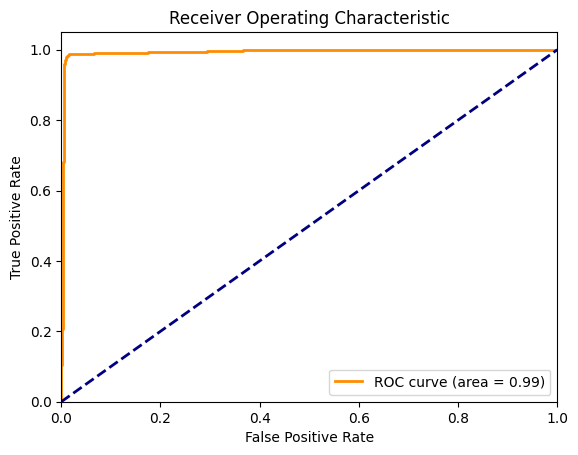

Log Loss: 0.0522


In [ ]:
!pip install scikit-image
from scipy.fft import fft2
from skimage.feature import local_binary_pattern
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
import numpy as np
from progressbar import progressbar
import glob
import cv2
import matplotlib.pyplot as plt

def extract_chromatic_channel(bgr_img):
    ycrcb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCR_CB)
    return ycrcb_image[:, :, 1:]

def block_processing(cb_image, block_size, stride):
    height, width, _ = cb_image.shape
    img_blocks = []
    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            img_blocks.append(cb_image[i: i + block_size, j: j + block_size])
    return np.array(img_blocks)

def extract_lbp_fft(blocks, n_points=8, radius=1):
    n_blocks, block_size, _, _ = blocks.shape
    CR_feature = np.zeros((n_blocks, block_size, block_size))
    CB_feature = np.zeros((n_blocks, block_size, block_size))

    for idx, block in enumerate(blocks):
        CR_lbp = local_binary_pattern(block[:, :, 0], n_points, radius)
        CB_lbp = local_binary_pattern(block[:, :, 1], n_points, radius)

        CR_lbp = np.float32(CR_lbp)
        CR_feature[idx] = np.abs(fft2(CR_lbp))

        CB_lbp = np.float32(CB_lbp)
        CB_feature[idx] = np.abs(fft2(CB_lbp))

    CR_feature = np.std(CR_feature, axis=0).flatten()
    CB_feature = np.std(CB_feature, axis=0).flatten()

    return np.concatenate([CR_feature, CB_feature], axis=0)

def kmeans_clustering(features, n_clusters=2):
    features = features.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    return kmeans.cluster_centers_.flatten()

def extract_feature(cb_image, block_size, stride, n_clusters=2):
    img_blocks = block_processing(cb_image, block_size, stride)
    lbp_fft_features = extract_lbp_fft(img_blocks)
    kmeans_features = kmeans_clustering(lbp_fft_features.reshape(-1, 1), n_clusters=n_clusters)
    return np.concatenate([lbp_fft_features, kmeans_features], axis=0)

def read_and_extract_feature(list_img, block_sizes, strides, n_clusters=2):
    total_img = len(list_img)
    dim = 0
    for bz in block_sizes:
        dim += bz ** 2
    features = np.zeros((total_img, 2 * dim + 2 * n_clusters))
    for idx in progressbar(range(len(list_img))):
        im = list_img[idx]
        bgr_img = cv2.imread(im)
        cb_image = extract_chromatic_channel(bgr_img)
        tmp = 0
        for i, bz in enumerate(block_sizes):
            extracted_features = extract_feature(cb_image, bz, strides[i], n_clusters=n_clusters)
            features[idx, tmp: tmp + len(extracted_features)] = extracted_features
            tmp += len(extracted_features)
    return features

def process_dataset(folders_real, folders_fake, block_sizes=[16], strides=[8], n_clusters=2):
    list_real = []
    list_fake = []
    for fdr in folders_real:
        list_real += glob.glob(fdr)
    for fdf in folders_fake:
        list_fake += glob.glob(fdf)
    Y_train = np.zeros((len(list_real) + len(list_fake),), dtype=np.float32)
    Y_train[: len(list_real)] = 1.0
    X_train = read_and_extract_feature(list_real + list_fake, block_sizes=block_sizes, strides=strides, n_clusters=n_clusters)
    return X_train, Y_train

if __name__ == '__main__':
    folder_real = ['/content/drive/MyDrive/CASIA2/negative/*.jpg']
    folder_fake = ['/content/drive/MyDrive/CASIA2/positive/*.jpg', '/content/drive/MyDrive/CASIA2/positive/*.tif']

    print('Processing dataset...')
    X, Y = process_dataset(folder_real, folder_fake)

    print('Shuffling data...')
    X, Y = shuffle(X, Y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply LDA for dimensionality reduction
    lda = LDA(n_components=1)
    X_lda = lda.fit_transform(X_scaled, Y)

    # Use GridSearchCV to find the best hyperparameters for SVM
    param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
    svm = SVC(probability=True)
    grid_search = GridSearchCV(svm, param_grid, cv=5)
    grid_search.fit(X_lda, Y)

    # Get the best model from grid search
    best_svm = grid_search.best_estimator_

    # Use cross_val_predict to get predictions for each fold
    y_pred = cross_val_predict(best_svm, X_lda, Y, cv=5)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)

    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    # Print metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Compute ROC curve and AUC
    y_prob = cross_val_predict(best_svm, X_lda, Y, cv=5, method='predict_proba')[:, 1]
    fpr, tpr, thresholds = roc_curve(Y, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Compute log loss
    loss = log_loss(Y, y_prob)
    print(f"Log Loss: {loss:.4f}")


In [ ]:
    # Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.9874840899448452
Precision: 0.9686897880539499
Recall: 0.9743217054263565
F1 Score: 0.9714975845410628


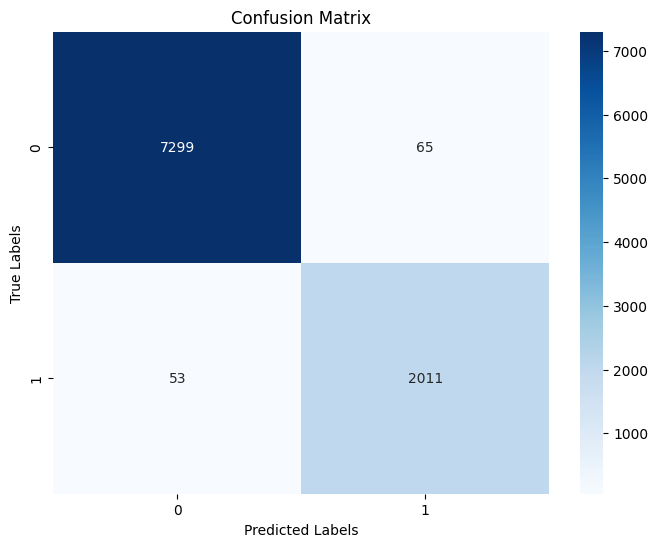

NameError: name 'classification_report' is not defined

In [ ]:
import seaborn as sns

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Calculate classification report
cr = classification_report(y_test, y_pred)
print("Classification Report:")
print(cr)

#KNN on FFT

In [ ]:
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, cross_val_predict
from scipy.fft import fft2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from progressbar import progressbar
import glob
import cv2

In [ ]:
def extract_chromatic_channel(bgr_img):
    # Extract 2 chromatic channes from BGR image
    # Input: BGR Image
    # Output: CrCb channels
    ycrcb_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCR_CB)
    return ycrcb_image[:, :, 1:]


def block_processing(cb_image, block_size, stride):
    # Divide image into multiple overlap blocks
    # Input: Cr or Cb channel
    # Output: List of blocks
    height, width, _ = cb_image.shape
    img_blocks = []
    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            img_blocks.append(cb_image[i: i + block_size, \
                j: j + block_size])
    return np.array(img_blocks)
def extract_lbp_fft(blocks, n_points=8, radius=1):
    n_blocks, block_size, _, _ = blocks.shape
    CR_feature = np.zeros((n_blocks, block_size, block_size))
    CB_feature = np.zeros((n_blocks, block_size, block_size))

    for idx, block in enumerate(blocks):
        # Extract LBP
        CR_lbp = local_binary_pattern(block[:, :, 0], n_points, radius)
        CB_lbp = local_binary_pattern(block[:, :, 1], n_points, radius)

        # Convert LBP to float32 and perform FFT
        CR_lbp = np.float32(CR_lbp)
        CR_feature[idx] = np.abs(fft2(CR_lbp))

        CB_lbp = np.float32(CB_lbp)
        CB_feature[idx] = np.abs(fft2(CB_lbp))

    # Calculate standard deviation along the blocks
    CR_feature = np.std(CR_feature, axis=0).flatten()
    CB_feature = np.std(CB_feature, axis=0).flatten()

    return np.concatenate([CR_feature, CB_feature], axis=0)

def extract_feature(cb_image, block_size, stride):
    img_blocks = block_processing(cb_image, block_size, stride)
    feature = extract_lbp_fft(img_blocks)
    return feature
def read_and_extract_feature(list_img, block_sizes, strides):
    # Read and extract feature vector from given list images
    total_img = len(list_img)
    dim = 0
    for i in range(len(block_sizes)):
        dim += block_sizes[i] ** 2
    features = np.zeros((total_img, 2*dim))
    for idx in progressbar(range(len(list_img))):
        im         = list_img[idx]
        bgr_img    = cv2.imread(im)
        cb_image   = extract_chromatic_channel(bgr_img)
        tmp        = 0
        for i, bz in enumerate(block_sizes):
            features[idx, tmp: tmp + 2*bz**2] = extract_feature(cb_image, bz, strides[i])
            tmp += 2*bz ** 2
    return features

def process_dataset(folders_real, folders_fake, block_sizes = [16], strides = [8]):
    # Process CASIA dataset
    # Label: 0 - fake image
    #        1 - real image
    list_real = []
    list_fake = []
    for fdr in folders_real:
        list_real += glob.glob(fdr)
    for fdf in folders_fake:
        list_fake += glob.glob(fdf)
    Y_train = np.zeros((len(list_real) + len(list_fake), ), dtype = np.float32)
    Y_train[: len(list_real)] = 1.0
    X_train = read_and_extract_feature(list_real + list_fake, block_sizes = block_sizes, strides = strides)
    return X_train, Y_train

In [ ]:
if __name__ == '__main__':
    folder_real = ['/content/drive/MyDrive/casia 1/Au/Au/*.jpg']
    folder_fake = ['/content/drive/MyDrive/casia 1/Tp/*.jpg', '/content/drive/MyDrive/casia 1/Tp/*.tif']

    print('Build kNN model ...')
    X, Y = process_dataset(folder_real, folder_fake)

    print('Build kNN model ...')
    X, Y = shuffle(X, Y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)

    # Choose the number of neighbors (you can adjust this parameter)
    k_value = 5
    knn = KNeighborsClassifier(n_neighbors=k_value)

    # Use cross_val_predict to get predictions for each fold
    y_pred = cross_val_predict(knn, X_train, Y, cv=5)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y, y_pred)

    # Extract TP, TN, FP, FN from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    print("True Positives:", tp)
    print("True Negatives:", tn)
    print("False Positives:", fp)
    print("False Negatives:", fn)

    # Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Build kNN model ...


100% (1711 of 1711) |####################| Elapsed Time: 0:16:42 Time:  0:16:42


Build kNN model ...
True Positives: 707
True Negatives: 818
False Positives: 103
False Negatives: 83
Accuracy: 0.891291642314436
Precision: 0.8728395061728395
Recall: 0.8949367088607595
F1 Score: 0.88375


In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
clf = xgb.XGBClassifier()
scores = cross_val_score(clf, X_train, Y, cv=5, scoring='f1_macro', n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


NameError: ignored

In [ ]:
import os
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False)

# Define a function to extract features from an image
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image to match VGG16 input size
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.flatten()  # Flatten the feature tensor into a 1D vector

# Directory paths for positive and negative images
positive_directory = '/content/drive/MyDrive/CASIA2/positive/'
negative_directory =  '/content/drive/MyDrive/CASIA2/negative/'
# List of image file names in the positive directory
positive_files = os.listdir(positive_directory)
# Filter out non-JPG files
positive_files = [f for f in positive_files if f.lower().endswith('.jpg')]
# Extract features from positive images
positive_features = []
for img_file in positive_files:
    img_path = os.path.join(positive_directory, img_file)
    features = extract_features(img_path)
    positive_features.append(features)

# List of image file names in the negative directory
negative_files = os.listdir(negative_directory)
# Filter out non-JPG files
negative_files = [f for f in negative_files if f.lower().endswith('.jpg')]
# Extract features from negative images
negative_features = []
for img_file in negative_files:
    img_path = os.path.join(negative_directory, img_file)
    features = extract_features(img_path)
    negative_features.append(features)

# Combine positive and negative features into a single feature vector
feature_vector = positive_features + negative_features

# Save the feature vector to a file
np.save('feature_vector.npy', feature_vector)

import numpy as np

# Load the saved feature vector from the file
loaded_vector = np.load('feature_vector.npy')

# Print the loaded feature vector
print(loaded_vector)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
[[ 0.         0.         0.        ...  0.         0.         1.6117983]
 [ 0.         0.         0.        ...  0.         3.5788512  0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 ...
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.        41.62486   ...  0.         0.        29.846899 ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]]


#xception model


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
# Load the feature vector from the saved file
feature_vector = np.load('feature_vector.npy')

# Generate labels for positive and negative examples
positive_labels = np.ones(len(positive_features))
negative_labels = np.zeros(len(negative_features))

# Combine the labels
labels = np.concatenate((positive_labels, negative_labels))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.2, random_state=42)

# Create an instance of the Xception model without the top layer
base_model = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a custom top layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Train the model
model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10)

# Make predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate classification report
cr = classification_report(y_test, y_pred)
print("Classification Report:")
print(cr)


83683744/83683744 [==============================] - 0s 0us/step


ValueError: ignored

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the feature vector from the saved file
feature_vector = np.load('feature_vector.npy')

# Generate labels for positive and negative examples
positive_labels = np.ones(len(positive_features))
negative_labels = np.zeros(len(negative_features))

# Combine the labels
labels = np.concatenate((positive_labels, negative_labels))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.2, random_state=42)

# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation up to 20 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    vertical_flip=True  # Random vertical flip
)


#Resnet101


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model

# Load the pre-trained ResNet-101 model (excluding the top layer)
resnet101 = ResNet101(weights='imagenet', include_top=False, input_shape=(X_train.shape[1],))

# Freeze the weights of the pre-trained layers
for layer in resnet101.layers:
    layer.trainable = False

# Add new trainable layers on top of the ResNet-101 model
x = resnet101.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the ResNet-101 model
model = Model(inputs=resnet101.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Make predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
"""
# Load the feature vector from the saved file
feature_vector = np.load('feature_vector.npy')

# Generate labels for positive and negative examples
positive_labels = np.ones(len(positive_features))
negative_labels = np.zeros(len(negative_features))

# Combine the labels
labels = np.concatenate((positive_labels, negative_labels))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.2, random_state=42)
"""
# Create an ANN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Make predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate classification report
cr = classification_report(y_test, y_pred)
print("Classification Report:")
print(cr)


Epoch 1/50
476/476 [==============================] - 7s 5ms/step - loss: 0.5045 - accuracy: 0.7643
Epoch 2/50
476/476 [==============================] - 3s 6ms/step - loss: 0.3465 - accuracy: 0.8461
Epoch 3/50
476/476 [==============================] - 4s 9ms/step - loss: 0.2952 - accuracy: 0.8662
Epoch 4/50
476/476 [==============================] - 5s 11ms/step - loss: 0.2477 - accuracy: 0.8872
Epoch 5/50
476/476 [==============================] - 4s 8ms/step - loss: 0.2322 - accuracy: 0.8935
Epoch 6/50
476/476 [==============================] - 5s 10ms/step - loss: 0.2189 - accuracy: 0.8987
Epoch 7/50
476/476 [==============================] - 5s 10ms/step - loss: 0.2100 - accuracy: 0.9017
Epoch 8/50
476/476 [==============================] - 2s 5ms/step - loss: 0.1983 - accuracy: 0.9064
Epoch 9/50
476/476 [==============================] - 3s 5ms/step - loss: 0.1883 - accuracy: 0.9100
Epoch 10/50
476/476 [==============================] - 2s 5ms/step - loss: 0.1839 - accuracy: 0.9

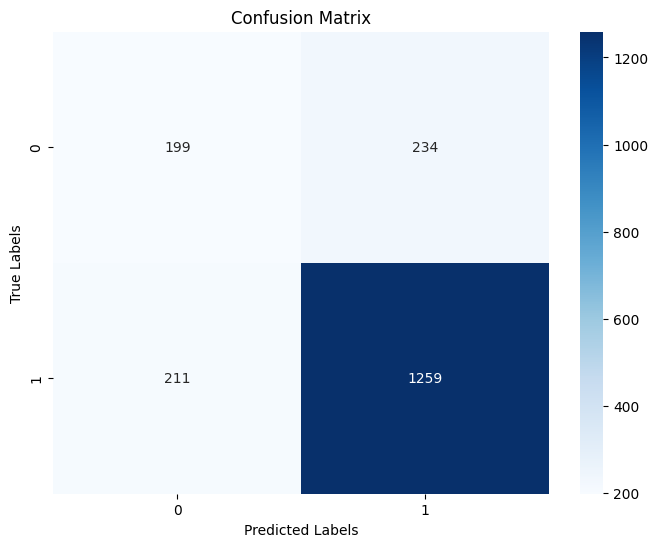

Classification Report:
              precision    recall  f1-score   support

         0.0       0.49      0.46      0.47       433
         1.0       0.84      0.86      0.85      1470

    accuracy                           0.77      1903
   macro avg       0.66      0.66      0.66      1903
weighted avg       0.76      0.77      0.76      1903



In [ ]:
# Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate classification report
cr = classification_report(y_test, y_pred)
print("Classification Report:")
print(cr)

In [ ]:
model.save('spmy1.h5')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image

# Load the feature vector from the saved file
feature_vector = np.load('feature_vector.npy')

# Load the pre-trained model
model = tf.keras.models.load_model('spmy1.h5')  # Replace 'your_model.h5' with your model's file name

# Load and preprocess the input image
input_image_path = '/content/drive/MyDrive/CASIA2/negative/Tp_D_CNN_M_B_nat00056_nat00099_11105.jpg'  # Replace 'your_input_image.jpg' with the path to your input image
input_image = load_img(input_image_path, target_size=(224, 224))
input_image_array = img_to_array(input_image)
input_image_array = np.expand_dims(input_image_array, axis=0)
input_image_array = preprocess_input(input_image_array)

# Predict the class probabilities
predictions = model.predict(input_image_array)
class_probabilities = predictions[0]

# Define threshold for classification
threshold = 0.5

# Determine the message based on the classification probability
if class_probabilities >= threshold:
    message = "The image is classified as positive."
else:
    message = "The image is classified as negative."

# Print the message
print(message)


In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the feature vector from the saved file
feature_vector = np.load('feature_vector.npy')

# Generate labels for positive and negative examples
positive_labels = np.ones(len(positive_features))
negative_labels = np.zeros(len(negative_features))

# Combine the labels
labels = np.concatenate((positive_labels, negative_labels))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.2, random_state=42)

# Create an SVM classifier
svm = SVC()

# Train the classifier
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 125  308]
 [  82 1388]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.29      0.39       433
         1.0       0.82      0.94      0.88      1470

    accuracy                           0.80      1903
   macro avg       0.71      0.62      0.63      1903
weighted avg       0.77      0.80      0.77      1903



In [ ]:
TP=cm[0][0] # class Spliced, predicted as Spliced
TN=cm[1][1] #class Authentic, predicted as Authentic
FN=cm[0][1] #class Spliced, predicted as Authentic
FP=cm[1][0] #class Authentic, predicted as Spliced

print("Accuracy=", ((TN+TP)/float(TN+TP+FP+FN))*100.00)
print("Precision=", (TP/float(TP+FP))*100.00)
print("Recall=" , (TP/float(TP+FN))*100.00)


Accuracy= 76.6158696794535
Precision= 48.536585365853654
Recall= 45.95842956120092


#XGBoost

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

# Load the feature vector from the saved file
feature_vector = np.load('feature_vector.npy')

# Generate labels for positive and negative examples
positive_labels = np.ones(len(positive_features))
negative_labels = np.zeros(len(negative_features))

# Combine the labels
labels = np.concatenate((positive_labels, negative_labels))

# Initialize K-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
confusion_matrices = []
classification_reports = []

# Perform K-fold cross-validation
for train_index, test_index in kfold.split(feature_vector):
    X_train, X_test = feature_vector[train_index], feature_vector[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Create an XGBoost classifier
    xgb_classifier = xgb.XGBClassifier()

    # Train the classifier
    xgb_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = xgb_classifier.predict(X_test)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

    # Calculate classification report
    report = classification_report(y_test, y_pred)
    classification_reports.append(report)

# Calculate average confusion matrix and classification report
avg_confusion_matrix = np.mean(confusion_matrices, axis=0)
avg_classification_report = '\n'.join(classification_reports)

# Print average confusion matrix
print("Average Confusion Matrix:")
print(avg_confusion_matrix)

# Print average classification report
print("Average Classification Report:")
print(avg_classification_report)


FileNotFoundError: ignored

In [ ]:
positives = glob('/content/drive/MyDrive/CASIA2/positive/*.jpg') # Authentic images
negatives = glob('/content/drive/MyDrive/CASIA2/negative/*.jpg') #spliced images


#Features=[] #Final Feature matrix


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
for im in (positives+negatives):
    img = cv2.imread(im) # read image one by one
    dataset = ImageFolder(img, transform=transforms)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

ValueError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = nn.Parameter(torch.FloatTensor(out_features))

    def forward(self, input, adj_matrix):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj_matrix, support)
        output = output + self.bias
        return output

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(input_dim, hidden_dim)
        self.gc2 = GraphConvolution(hidden_dim, output_dim)

    def forward(self, input, adj_matrix):
        x = F.relu(self.gc1(input, adj_matrix))
        x = self.gc2(x, adj_matrix)
        return x

# Set the path to your image dataset
dataset_path = "/path/to/your/dataset"

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load the image dataset
dataset = ImageFolder(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Create adjacency matrix based on spatial connectivity
num_pixels = 256 * 256
adj_matrix = torch.eye(num_pixels)

# Define the GCN model
input_dim = 3  # Assuming RGB images
hidden_dim = 64
output_dim = 128
model = GCN(input_dim, hidden_dim, output_dim)

# Extract image features and store with labels
Features = []
Labels = []
for images, labels in dataloader:
    batch_size = images.size(0)
    images = images.view(batch_size, input_dim, -1)  # Reshape images to (batch_size, C, num_pixels)
    features = model(images, adj_matrix)
    features = features.detach().numpy()  # Convert tensor to numpy array
    Features.append(features)
    Labels.append(labels)

# Convert Features and Labels lists to numpy arrays
Features = np.concatenate(Features, axis=0)
Labels = np.concatenate(Labels, axis=0)

print(Features.shape)  # Shape: (num_images, output_dim, num_pixels)
print(Labels.shape)  # Shape: (num_images,)